# Description
This notebook gives an example of denoising a spectrum map with PCA as implemented in hyperspy. We start from an experimental EMD file and use TEMMETA to load in the datasets.

In [1]:
%matplotlib notebook

In [2]:
from skimage.filters import gaussian
from temmeta import data_io as dio
from temmeta import image_filters as imf
import hyperspy.api as hs
import os
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

/Users/nielscautaerts/opt/anaconda3/envs/devel/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [3]:
file_path = os.path.abspath("../data/Wenjun/20200206/sigma13 13.5 Mx EDS-HAADF-DF4 1445 20191205 SI.emd")
print(file_path)

/Users/nielscautaerts/Documents/Work/Projects/191007RHEA-SRO/data/Wenjun/20200206/sigma13 13.5 Mx EDS-HAADF-DF4 1445 20191205 SI.emd


## 1 Open file, download the file if necessary

In [4]:
import wget

try:
    f = dio.EMDFile(file_path)
except Exception as e:
    print(f"Could not locate file: {e}. Will attempt download.")
    url = "https://owncloud.gwdg.de/index.php/s/hb7QFFl2EswRpZA/download"
    folder, filename = os.path.split(file_path)
    if not os.path.isdir(folder):
        os.makedirs(folder)
    wget.download(url, file_path)
    f = dio.EMDFile(file_path)

## 2 Get the HAADF and SpectrumStream datasets

In [5]:
# HAADF image stack
path = f.find_dataset("Detector", "HAADF")[0].name
uuid = path.split("/")[3]
imstack = f.get_dataset("Image", uuid)
# spectrum stream
uuid_ss = f._get_ds_uuid("SpectrumStream", 0)
specstr = f.get_dataset("SpectrumStream", uuid_ss)
# spectrum map
specmap = specstr.spectrum_map

In [8]:
import json

In [13]:
from temmeta import metadata

In [16]:
metadata.Metadata(specstr.original_metadata).to_file("original_velox_metadata.json")

<IPython.core.display.Javascript object>


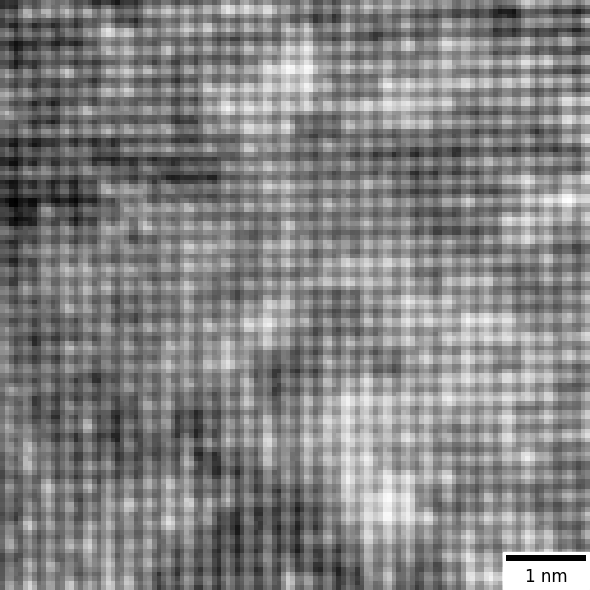

(<matplotlib.axes._axes.Axes at 0x1304c48d0>,
 <matplotlib.image.AxesImage at 0x1304366d0>)

In [6]:
imstack.average.rebin(4).plot()

## 3 Convert to Hyperspy objects
* Bin and blur the dataset
* Run the PCA analysis

In [29]:
4096/8

512.0

In [36]:
specmap_hs = specmap.to_hspy()
specmap_hs.set_signal_type("EDS_TEM")

specmap_hs = specmap_hs.rebin(scale=(8, 4, 4))
specmap_hs.change_dtype("float64")
# blur with a gaussian
gmap = lambda x: gaussian(x, sigma=2, preserve_range=True, truncate=8)
specmap_hs.map(gmap, inplace=True, parallel=True)
specmap_hs.crop("Energy", start=1.0, end=18.5)
# specmap_hs.crop("scan_x", 2, 61)
# specmap_hs.crop("scan_y", 2, 61)

specmap_hs = specmap_hs.T

In [37]:
specmap_hs.axes_manager

<Axes manager, axes: (128, 128|219)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
          scan_y |    128 |      0 | 2.2e-11 | 5.8e-11 |      m 
          scan_x |    128 |      0 | 2.2e-11 | 5.8e-11 |      m 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |    219 |        |       1 |    0.08 |    keV

<IPython.core.display.Javascript object>


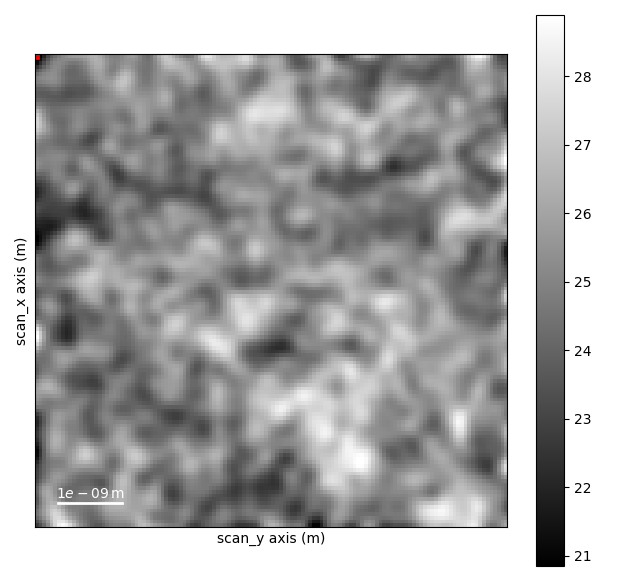

<IPython.core.display.Javascript object>


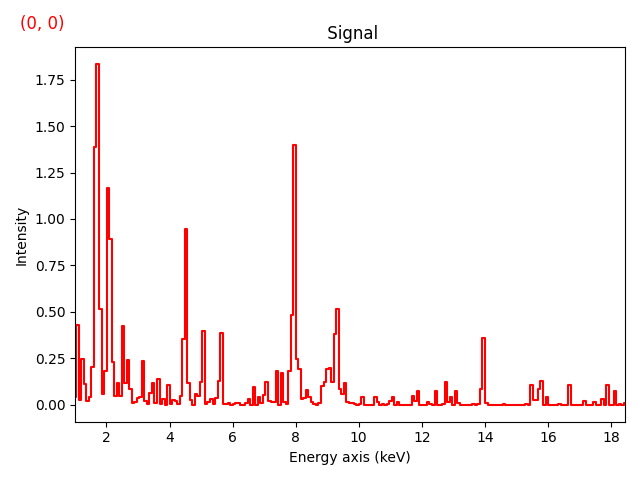

In [38]:
specmap_hs.plot()

In [9]:
specmap_hs.decomposition(algorithm = "SVD",
                        normalize_poissonian_noise=True,
                        output_dimension=None,
                        centre=None)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<IPython.core.display.Javascript object>


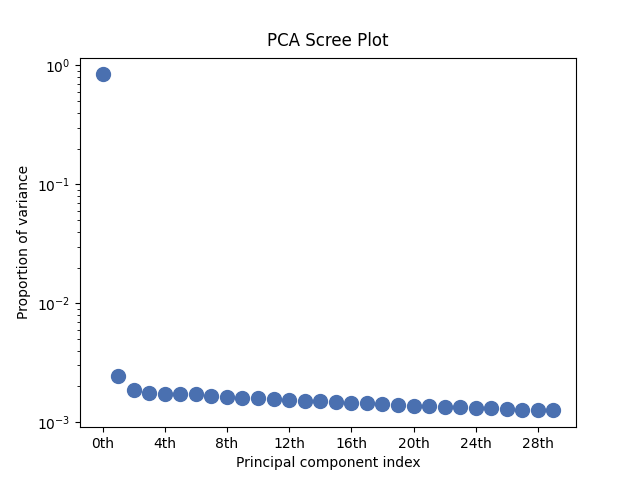

<AxesSubplot:title={'center':'\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

In [10]:
specmap_hs.plot_explained_variance_ratio()

<IPython.core.display.Javascript object>


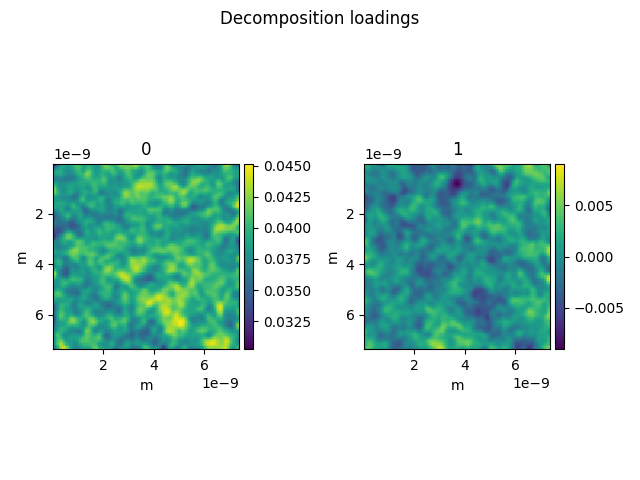

<IPython.core.display.Javascript object>


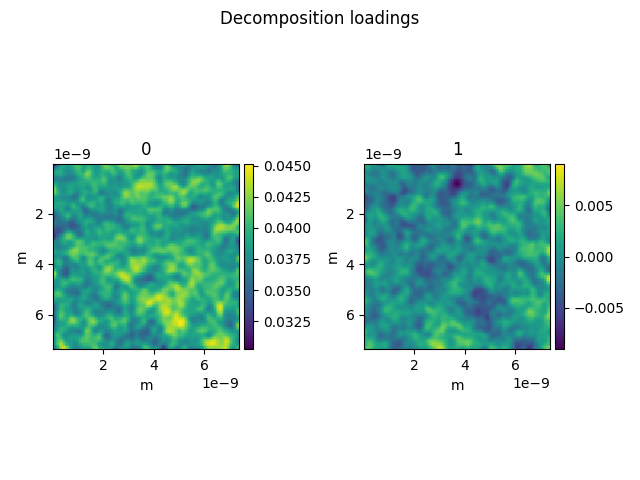

In [12]:
specmap_hs.plot_decomposition_loadings(2, cmap="viridis")

In [13]:
specmap_model = specmap_hs.get_decomposition_model(2)

## 4. Making the figures

In [14]:
# Convert back to temmeta because it's easier
mspecmap = dio.create_new_spectrum_map(specmap_model.T.data,
                            specmap_model.axes_manager["scan_x"].scale,
                            specmap_model.axes_manager["scan_x"].units,
                            specmap_model.axes_manager["Energy"].scale,
                            specmap_model.axes_manager["Energy"].units,
                            specmap_model.axes_manager["Energy"].offset,
                            )

specmap = dio.create_new_spectrum_map(specmap_hs.T.data,
                            specmap_hs.axes_manager["scan_x"].scale,
                            specmap_hs.axes_manager["scan_x"].units,
                            specmap_hs.axes_manager["Energy"].scale,
                            specmap_hs.axes_manager["Energy"].units,
                            specmap_hs.axes_manager["Energy"].offset,
                            )

The energy ranges to integrate between

In [16]:
hfta = [1.2, 1.9]
zr1 = [1.98, 2.29]
ti1 = [4.3, 5.1]
hf1 = [7.76, 8.05]
ta1 = [8.05, 8.33]
hf2 = [8.85, 9.2]
ta2 = [9.2, 9.54]
hf3 = [10.37, 10.7]
zr2 = [15.80-0.7/2, 15.80+0.7/2]
zr3 = [17.68-0.7/2, 17.68+0.7/2]

Visualize the ranges

<IPython.core.display.Javascript object>


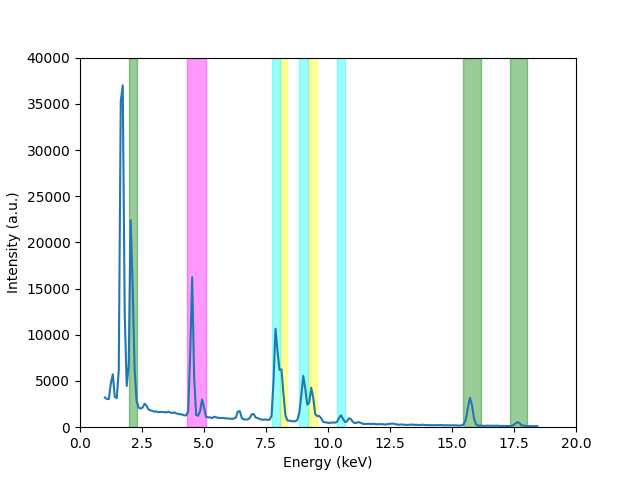

In [23]:
spectrum = mspecmap.spectrum

mx = 40000
alph=0.4

ax, _ = spectrum.plot()
ax.set_ylim(0,mx)
ax.set_xlim(0, 20)

y = [0,mx]
#ax.fill_betweenx(y, [hfta[0]]*2, [hfta[1]]*2, color = "cyan", alpha=alph)

ax.fill_betweenx(y, [zr1[0]]*2, [zr1[1]]*2, color = "green", alpha=alph)
ax.fill_betweenx(y, [zr2[0]]*2, [zr2[1]]*2, color = "green", alpha=alph)
ax.fill_betweenx(y, [zr3[0]]*2, [zr3[1]]*2, color = "green", alpha=alph)
ax.fill_betweenx(y, [ti1[0]]*2, [ti1[1]]*2, color = "magenta", alpha=alph)
ax.fill_betweenx(y, [ta1[0]]*2, [ta1[1]]*2, color = "yellow", alpha=alph)
ax.fill_betweenx(y, [ta2[0]]*2, [ta2[1]]*2, color = "yellow", alpha=alph)
ax.fill_betweenx(y, [hf1[0]]*2, [hf1[1]]*2, color = "cyan", alpha=alph)
ax.fill_betweenx(y, [hf2[0]]*2, [hf2[1]]*2, color = "cyan", alpha=alph)
ax.fill_betweenx(y, [hf3[0]]*2, [hf3[1]]*2, color = "cyan", alpha=alph)

Create integrated images

In [15]:
mHFTA = mspecmap.integrate_to_image((hfta[0]+hfta[1])/2, hfta[1]-hfta[0])
mZr1 = mspecmap.integrate_to_image((zr1[0]+zr1[1])/2, zr1[1]-zr1[0])
mTi1 = mspecmap.integrate_to_image((ti1[0]+ti1[1])/2, ti1[1]-ti1[0])
mHf1 = mspecmap.integrate_to_image((hf1[0]+hf1[1])/2, hf1[1]-hf1[0])
mTa1 = mspecmap.integrate_to_image((ta1[0]+ta1[1])/2, ta1[1]-ta1[0])
mHf2 = mspecmap.integrate_to_image((hf2[0]+hf2[1])/2, hf2[1]-hf2[0])
mTa2 = mspecmap.integrate_to_image((ta2[0]+ti1[1])/2, ta2[1]-ta2[0])
mHf3 = mspecmap.integrate_to_image((hf3[0]+hf3[1])/2, hf3[1]-hf3[0])
mZr2 = mspecmap.integrate_to_image((zr2[0]+zr2[1])/2, zr2[1]-zr2[0])
mZr3 = mspecmap.integrate_to_image((zr3[0]+zr3[1])/2, zr3[1]-zr3[0])

mZr_im = mZr1+mZr2+mZr3 # sum of all Zr peaks
mTi_im = mTi1 # sum of all titanium peaks
mTa_im = mTa1+mTa2 # sum of all yellow peaks (only ta)
mHf_im = mHf1+mHf2+mHf3 # sum of all blue peaks, all hf
mTaHf_im = mTa_im + mHf_im + mHFTA # sum of Ta and Hf
mTaP_im = mTa_im+mHFTA  # sum of Ta and peak where Hf and Ta overlap
mTiZr_im = mTi_im + mZr_im # sum of Ti and Zr

HFTA = specmap.integrate_to_image((hfta[0]+hfta[1])/2, hfta[1]-hfta[0])
Zr1 = specmap.integrate_to_image((zr1[0]+zr1[1])/2, zr1[1]-zr1[0])
Ti1 = specmap.integrate_to_image((ti1[0]+ti1[1])/2, ti1[1]-ti1[0])
Hf1 = specmap.integrate_to_image((hf1[0]+hf1[1])/2, hf1[1]-hf1[0])
Ta1 = specmap.integrate_to_image((ta1[0]+ta1[1])/2, ta1[1]-ta1[0])
Hf2 = specmap.integrate_to_image((hf2[0]+hf2[1])/2, hf2[1]-hf2[0])
Ta2 = specmap.integrate_to_image((ta2[0]+ti1[1])/2, ta2[1]-ta2[0])
Hf3 = specmap.integrate_to_image((hf3[0]+hf3[1])/2, hf3[1]-hf3[0])
Zr2 = specmap.integrate_to_image((zr2[0]+zr2[1])/2, zr2[1]-zr2[0])
Zr3 = specmap.integrate_to_image((zr3[0]+zr3[1])/2, zr3[1]-zr3[0])

Zr_im = Zr1+Zr2+Zr3 # sum of all Zr peaks
Ti_im = Ti1 # sum of all titanium peaks
Ta_im = Ta1+Ta2 # sum of all yellow peaks (only ta)
Hf_im = Hf1+Hf2+Hf3 # sum of all blue peaks, all hf
TaHf_im = Ta_im + Hf_im + HFTA # sum of Ta and Hf
TaP_im = Ta_im+HFTA  # sum of Ta and peak where Hf and Ta overlap
TiZr_im = Ti_im + Zr_im # sum of Ti and Zr

<IPython.core.display.Javascript object>


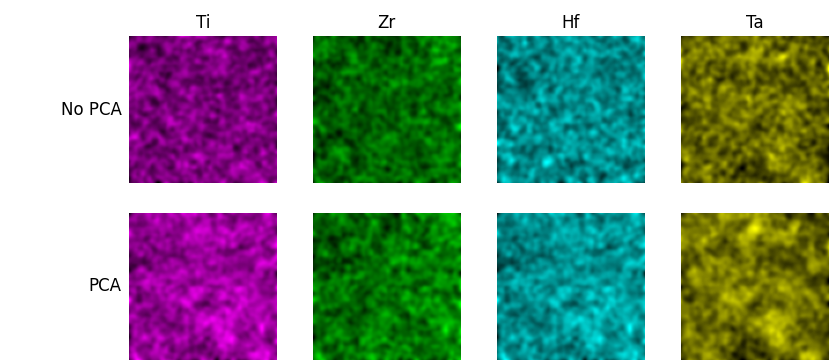

In [25]:
import matplotlib.colors as colors

scale = 1.2

fig, ax = plt.subplots(2, 4, figsize=(7*scale, 3.*scale))
# This dictionary defines the colormap
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (1.0, 1.0, 1.0)),  # all red at 1

        'green': ((0.0, 0.0, 0.0),   # no green at 0
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (1.0, 1.0, 1.0))   # no blue at 1
       }
RdBlck = colors.LinearSegmentedColormap('RdBlck', cdict)
# This dictionary defines the colormap
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (1.0, 0.0, 0.0)),  # all red at 1

        'green': ((0.0, 0.0, 0.0),   # no green at 0
                  (1.0, 1.0, 1.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (1.0, 0.0, 0.0))   # no blue at 1
       }
GrnBlck = colors.LinearSegmentedColormap('GrnBlck', cdict)
# This dictionary defines the colormap
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (1.0, 0.0, 0.0)),  # all red at 1

        'green': ((0.0, 0.0, 0.0),   # no green at 0
                  (1.0, 1.0, 1.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (1.0, 1.0, 1.0))   # no blue at 1
       }
BluBlck = colors.LinearSegmentedColormap('RdBlck', cdict)
# This dictionary defines the colormap
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (1.0, 1.0, 1.0)),  # all red at 1

        'green': ((0.0, 0.0, 0.0),   # no green at 0
                  (1.0, 1.0, 1.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (1.0, 0.0, 0.0))   # no blue at 1
       }
YBlck = colors.LinearSegmentedColormap('YBlck', cdict)
ax[1,0].imshow(mTi_im.data, cmap=RdBlck)
ax[0,0].set_title("Ti")
ax[1,1].imshow(mZr_im.data, cmap=GrnBlck)
ax[0,1].set_title("Zr")
ax[1,2].imshow(mHf_im.data, cmap=BluBlck)
ax[0,2].set_title("Hf")
ax[1,3].imshow(mTa_im.data, cmap=YBlck)
ax[0,3].set_title("Ta")
ax[0,0].imshow(Ti_im.data, cmap=RdBlck)
ax[0,1].imshow(Zr_im.data, cmap=GrnBlck)
ax[0,2].imshow(Hf_im.data, cmap=BluBlck)
ax[0,3].imshow(Ta_im.data, cmap=YBlck)
for i in ax.flatten():
    i.set_axis_off()

fs = 12
ax[0,0].text(-.05, .5, "No PCA", va='center', ha='right', fontsize=fs, transform = ax[0,0].transAxes)
ax[1,0].text(-.05, .5, "PCA", va='center', ha='right', fontsize=fs, transform = ax[1,0].transAxes)

fig.subplots_adjust(top=0.9, bottom=0, left=0.15, right=0.99)

# Repeat for other dataset

In [39]:
file_path_def = os.path.abspath("../data/ds1_nrr/results_004/spectrumDeformed.hspy")
file_path_udef = os.path.abspath("../data/ds1_nrr/results_004/spectrumUndeformed.hspy")
print(file_path_def)
print(file_path_udef)

/Users/nielscautaerts/Documents/Work/Projects/191007RHEA-SRO/data/ds1_nrr/results_004/spectrumDeformed.hspy


In [62]:
try:
    f_def = hs.load(file_path_def)
except Exception as e:
    print(f"Could not locate file: {e}. Will attempt download.")
    url = ""
    folder, filename = os.path.split(file_path_def)
    if not os.path.isdir(folder):
        os.makedirs(folder)
    wget.download(url, file_path_def)
    f_def = hs.load(file_path_def)
    
try:
    f_udef = hs.load(file_path_udef)
except Exception as e:
    print(f"Could not locate file: {e}. Will attempt download.")
    url = ""
    folder, filename = os.path.split(file_path_udef)
    if not os.path.isdir(folder):
        os.makedirs(folder)
    wget.download(url, file_path_udef)
    f_udef = hs.load(file_path_udef)

In [56]:
f_udef.data.shape

(4096, 128, 128)

<IPython.core.display.Javascript object>


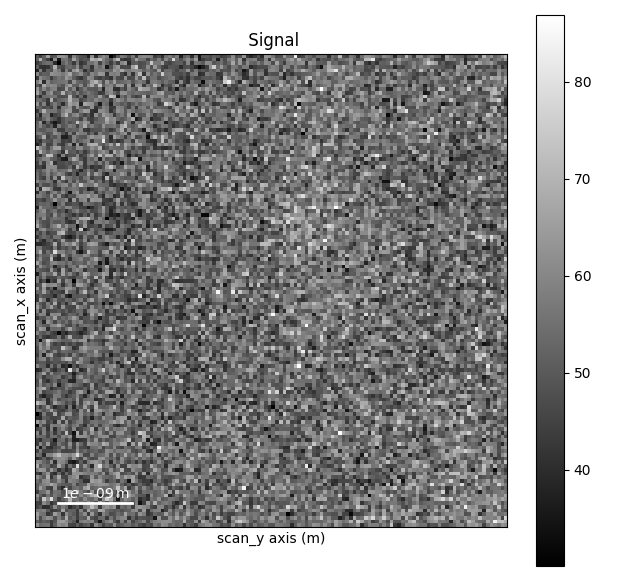

In [57]:
f_udef.sum().plot()

In [63]:
ebin = 8
sigma = 0.8
trunc = sigma*4

f_def.set_signal_type("EDS_TEM")
f_def = f_def.rebin(scale=(ebin, 1, 1))
f_def.change_dtype("float64")
# blur with a gaussian
gmap = lambda x: gaussian(x, sigma=sigma, preserve_range=True, truncate=trunc)
f_def.map(gmap, inplace=True, parallel=True)
f_def.crop("Energy", start=1.0, end=18.5)

f_udef.set_signal_type("EDS_TEM")
f_udef = f_udef.rebin(scale=(ebin, 1, 1))
f_udef.change_dtype("float64")
# blur with a gaussian
gmap = lambda x: gaussian(x, sigma=sigma, preserve_range=True, truncate=trunc)
f_udef.map(gmap, inplace=True, parallel=True)
f_udef.crop("Energy", start=1.0, end=18.5)

# Convert back to temmeta because it's easier
specmap_def = dio.create_new_spectrum_map(f_def.data,
                            f_def.axes_manager["scan_x"].scale,
                            f_def.axes_manager["scan_x"].units,
                            f_def.axes_manager["Energy"].scale,
                            f_def.axes_manager["Energy"].units,
                            f_def.axes_manager["Energy"].offset,
                            )

specmap_udf = dio.create_new_spectrum_map(f_udef.data,
                            f_udef.axes_manager["scan_x"].scale,
                            f_udef.axes_manager["scan_x"].units,
                            f_udef.axes_manager["Energy"].scale,
                            f_udef.axes_manager["Energy"].units,
                            f_udef.axes_manager["Energy"].offset,
                            )

<IPython.core.display.Javascript object>


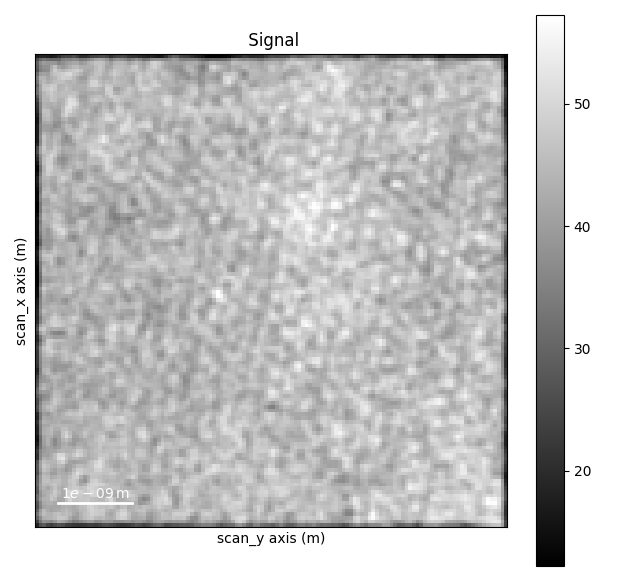

In [65]:
f_def.sum().plot()

<IPython.core.display.Javascript object>


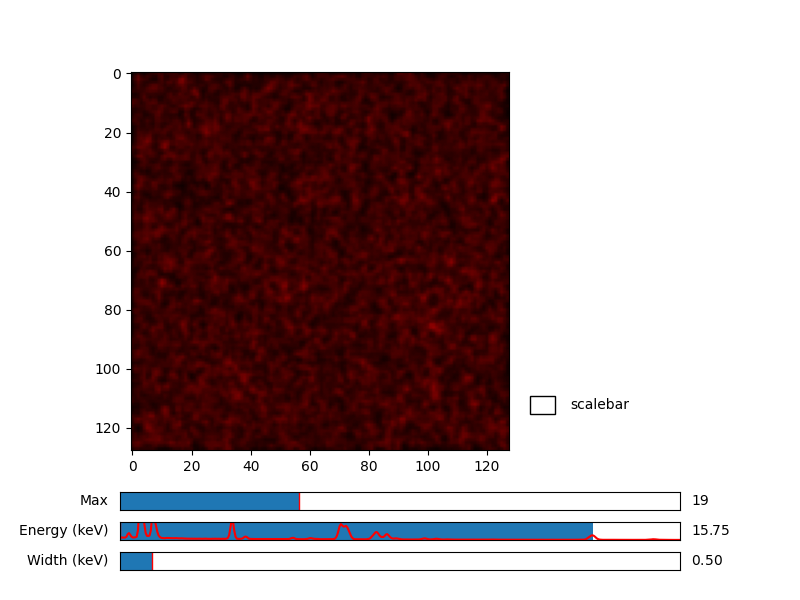

In [66]:
specmap_def.plot_interactive()

In [67]:
# with nrr
mHFTA = specmap_def.integrate_to_image((hfta[0]+hfta[1])/2, hfta[1]-hfta[0])
mZr1 = specmap_def.integrate_to_image((zr1[0]+zr1[1])/2, zr1[1]-zr1[0])
mTi1 = specmap_def.integrate_to_image((ti1[0]+ti1[1])/2, ti1[1]-ti1[0])
mHf1 = specmap_def.integrate_to_image((hf1[0]+hf1[1])/2, hf1[1]-hf1[0])
mTa1 = specmap_def.integrate_to_image((ta1[0]+ta1[1])/2, ta1[1]-ta1[0])
mHf2 = specmap_def.integrate_to_image((hf2[0]+hf2[1])/2, hf2[1]-hf2[0])
mTa2 = specmap_def.integrate_to_image((ta2[0]+ti1[1])/2, ta2[1]-ta2[0])
mHf3 = specmap_def.integrate_to_image((hf3[0]+hf3[1])/2, hf3[1]-hf3[0])
mZr2 = specmap_def.integrate_to_image((zr2[0]+zr2[1])/2, zr2[1]-zr2[0])
mZr3 = specmap_def.integrate_to_image((zr3[0]+zr3[1])/2, zr3[1]-zr3[0])

mZr_im = mZr1+mZr2+mZr3 # sum of all Zr peaks
mTi_im = mTi1 # sum of all titanium peaks
mTa_im = mTa1+mTa2 # sum of all yellow peaks (only ta)
mHf_im = mHf1+mHf2+mHf3 # sum of all blue peaks, all hf
mTaHf_im = mTa_im + mHf_im + mHFTA # sum of Ta and Hf
mTaP_im = mTa_im+mHFTA  # sum of Ta and peak where Hf and Ta overlap
mTiZr_im = mTi_im + mZr_im # sum of Ti and Zr

# no nrr
HFTA = specmap_udf.integrate_to_image((hfta[0]+hfta[1])/2, hfta[1]-hfta[0])
Zr1 = specmap_udf.integrate_to_image((zr1[0]+zr1[1])/2, zr1[1]-zr1[0])
Ti1 = specmap_udf.integrate_to_image((ti1[0]+ti1[1])/2, ti1[1]-ti1[0])
Hf1 = specmap_udf.integrate_to_image((hf1[0]+hf1[1])/2, hf1[1]-hf1[0])
Ta1 = specmap_udf.integrate_to_image((ta1[0]+ta1[1])/2, ta1[1]-ta1[0])
Hf2 = specmap_udf.integrate_to_image((hf2[0]+hf2[1])/2, hf2[1]-hf2[0])
Ta2 = specmap_udf.integrate_to_image((ta2[0]+ti1[1])/2, ta2[1]-ta2[0])
Hf3 = specmap_udf.integrate_to_image((hf3[0]+hf3[1])/2, hf3[1]-hf3[0])
Zr2 = specmap_udf.integrate_to_image((zr2[0]+zr2[1])/2, zr2[1]-zr2[0])
Zr3 = specmap_udf.integrate_to_image((zr3[0]+zr3[1])/2, zr3[1]-zr3[0])

Zr_im = Zr1+Zr2+Zr3 # sum of all Zr peaks
Ti_im = Ti1 # sum of all titanium peaks
Ta_im = Ta1+Ta2 # sum of all yellow peaks (only ta)
Hf_im = Hf1+Hf2+Hf3 # sum of all blue peaks, all hf
TaHf_im = Ta_im + Hf_im + HFTA # sum of Ta and Hf
TaP_im = Ta_im+HFTA  # sum of Ta and peak where Hf and Ta overlap
TiZr_im = Ti_im + Zr_im # sum of Ti and Zr

<IPython.core.display.Javascript object>


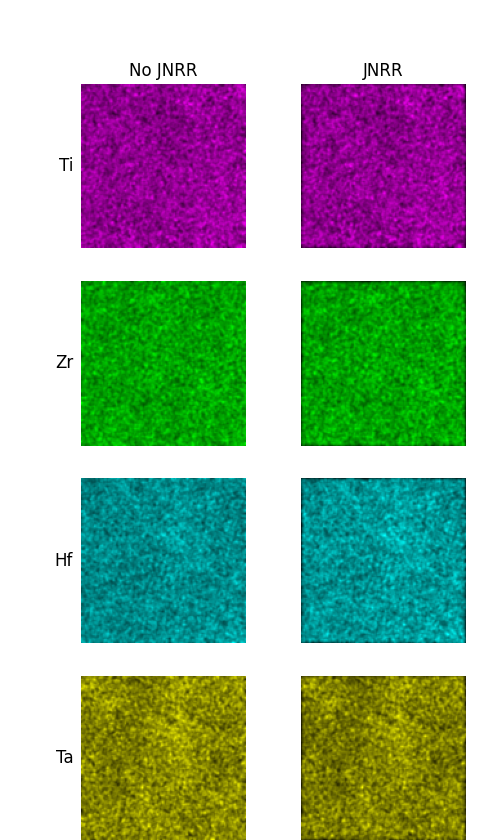

In [78]:
scale = 1.2

fig, ax = plt.subplots(4, 2, figsize=(4*scale, 7.*scale))
ax[0,0].set_title("No JNRR")
ax[0,1].set_title("JNRR")

vti = 0
vzr = 0
vhf = 0
vta = 0

ax[0,0].imshow(Ti_im.data, cmap=RdBlck, vmin=vti)
ax[0,1].imshow(mTi_im.data, cmap=RdBlck, vmin=vti)

ax[1,0].imshow(Zr_im.data, cmap=GrnBlck, vmin=vzr)
ax[1,1].imshow(mZr_im.data, cmap=GrnBlck, vmin=vzr)

ax[2,0].imshow(Hf_im.data, cmap=BluBlck, vmin=vhf)
ax[2,1].imshow(mHf_im.data, cmap=BluBlck, vmin=vhf)

ax[3,0].imshow(Ta_im.data, cmap=YBlck, vmin=vta)
ax[3,1].imshow(mTa_im.data, cmap=YBlck, vmin=vta)

# ax[0,0].imshow(Ti_im.data, cmap=RdBlck)
# ax[0,1].imshow(mTi_im.data, cmap=RdBlck)

# ax[1,0].imshow(Zr_im.data, cmap=GrnBlck)
# ax[1,1].imshow(mZr_im.data, cmap=GrnBlck)

# ax[2,0].imshow(Hf_im.data, cmap=BluBlck, vmin=0)
# ax[2,1].imshow(mHf_im.data, cmap=BluBlck, vmin=0)

# ax[3,0].imshow(Ta_im.data, cmap=YBlck)
# ax[3,1].imshow(mTa_im.data, cmap=YBlck)

for i in ax.flatten():
    i.set_axis_off()

fs = 12
ax[0,0].text(-.05, .5, "Ti", va='center', ha='right', fontsize=fs, transform = ax[0,0].transAxes)
ax[1,0].text(-.05, .5, "Zr", va='center', ha='right', fontsize=fs, transform = ax[1,0].transAxes)
ax[2,0].text(-.05, .5, "Hf", va='center', ha='right', fontsize=fs, transform = ax[2,0].transAxes)
ax[3,0].text(-.05, .5, "Ta", va='center', ha='right', fontsize=fs, transform = ax[3,0].transAxes)

fig.subplots_adjust(top=0.9, bottom=0, left=0.15, right=0.99)

In [73]:
plt.close("all")